# Libraries

In [3]:
import pandas as pd
import inflection
import missingno as msno
import seaborn as sns
import numpy as np
import re

import scipy.stats as stats
from scipy import stats as ss
from scipy.stats import chi2_contingency
from matplotlib import pyplot as plt
from IPython.display import Image
from utils import *

import ipywidgets as widgets
from ipywidgets import interact
import plotly.express as px

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, CDSView, IndexFilter
from bokeh.layouts import row, column
from scipy.stats import gaussian_kde
from bokeh.models import RangeSlider

from sklearn import preprocessing as pp
from imblearn import under_sampling as us
from imblearn import over_sampling as oversamp
from pandas_profiling import ProfileReport
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection as ms
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec
from sklearn.cluster import DBSCAN

import random
from sklearn import metrics as m
from sklearn.metrics import classification_report, cohen_kappa_score, roc_curve, brier_score_loss
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, recall_score, f1_score, roc_auc_score, precision_score, roc_curve
#from sklearn.metrics import plot_precision_recall_curve

from scikitplot import metrics as mt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
import category_encoders

from datetime import datetime, timedelta
import pickle

# Loading Data

In [1]:
pwd

'/Users/lucasquemelli/Documents/repos/credit_risk_assessment'

In [4]:
data = pd.read_csv("/Users/lucasquemelli/Documents/repos/credit_risk_assessment/credit_risk_dataset.csv")
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
data.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

# Duplication Analysis

Since this analysis should be at user level, would it be affordable to have repeated rows?
        
        * Ideally, we should have some column-key such as userid to identify any specific user. 

In [7]:
data.shape[0]

32581

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
data.shape[0]

32416

# Helper Functions

In [10]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y).values
    n = confusion_matrix.sum()
    r,k = confusion_matrix.shape
   
    chi2 = chi2_contingency(confusion_matrix)[0]
    phi2 = chi2/n
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
   
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# 1. Data Description

In [12]:
df1 = data.copy()

- person_age: Age of the individual applying for the loan.

- person_income: Annual income of the individual.

- person_home_ownership: Type of home ownership of the individual.

        - rent: The individual is currently renting a property.
        - mortgage: The individual has a mortgage on the property they own.
        - own: The individual owns their home outright.
        - other: Other categories of home ownership that may be specific to the dataset.
        
- person_emp_length: Employment length of the individual in years.

- loan_intent: The intent behind the loan application.

- loan_grade: The grade assigned to the loan based on the creditworthiness of the borrower.

        - A: The borrower has a high creditworthiness, indicating low risk.
        - B: The borrower is relatively low-risk, but not as creditworthy as Grade A.
        - C: The borrower's creditworthiness is moderate.
        - D: The borrower is considered to have higher risk compared to previous grades.
        - E: The borrower's creditworthiness is lower, indicating a higher risk.
        - F: The borrower poses a significant credit risk.
        - G: The borrower's creditworthiness is the lowest, signifying the highest risk.
        
- loan_amnt: The loan amount requested by the individual.

- loan_int_rate: The interest rate associated with the loan.

- loan_status: Loan status, where 0 indicates non-default and 1 indicates default.

        - 0: Non-default - The borrower successfully repaid the loan as agreed, and there was no default.
        - 1: Default - The borrower failed to repay the loan according to the agreed-upon terms and defaulted on the loan.
        
- loan_percent_income: The percentage of income represented by the loan amount.

- cb_person_default_on_file: Historical default of the individual as per credit bureau records.

        - Y: The individual has a history of defaults on their credit file.
        - N: The individual does not have any history of defaults.
        
- cb_person_cred_hist_length: The length of credit history for the individual.

## 1.1. Data Dimensions

In [13]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 32416
Number of cols: 12


## 1.2. Data Types

In [14]:
df1.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

## 1.3. Na Check

In [15]:
df1.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [19]:
df1["person_emp_length"].min()

0.0

In [18]:
df1["loan_int_rate"].min()

5.42

In [20]:
df1["loan_int_rate"].max()

23.22

In [21]:
df1["person_emp_length"] = df1["person_emp_length"].fillna(-1.0)

df1["loan_int_rate"] = df1["loan_int_rate"].fillna(-1.0)

In [22]:
df1.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

## 1.4. Descriptive Statistics

In [23]:
num_attributes = df1.select_dtypes(include=['int32', 'int64', 'float32', 'float64'])
cat_attributes = df1.select_dtypes(include=['object', 'category'])

### 1.4.1. Numerical Attributes

In [24]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,person_age,20.000,144.000,124.000,27.747,26.000,6.354,2.580,18.560
1,person_income,4000.000,6000000.000,5996000.000,66091.641,55000.000,62014.624,32.959,2701.116
2,person_emp_length,-1.000,123.000,124.000,4.632,4.000,4.196,2.499,40.846
3,loan_amnt,500.000,35000.000,34500.000,9593.846,8000.000,6322.633,1.192,1.421
4,loan_int_rate,-1.000,23.220,24.220,9.870,10.620,4.688,-0.798,0.461
5,loan_status,0.000,1.000,1.000,0.219,0.000,0.413,1.361,-0.147
6,loan_percent_income,0.000,0.830,0.830,0.170,0.150,0.107,1.064,1.218
7,cb_person_cred_hist_length,2.000,30.000,28.000,5.811,4.000,4.059,1.659,3.706


- There is no person in the world with age of 144. We must treat outliers for person_age.
- person_emp_length equals to 123 seems inadequate. We must analyze with a distribution to idenfify outliers.
- It seems the majority of people have lower income, since we found a high standard deviation and positive skew.

#### Person Age

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


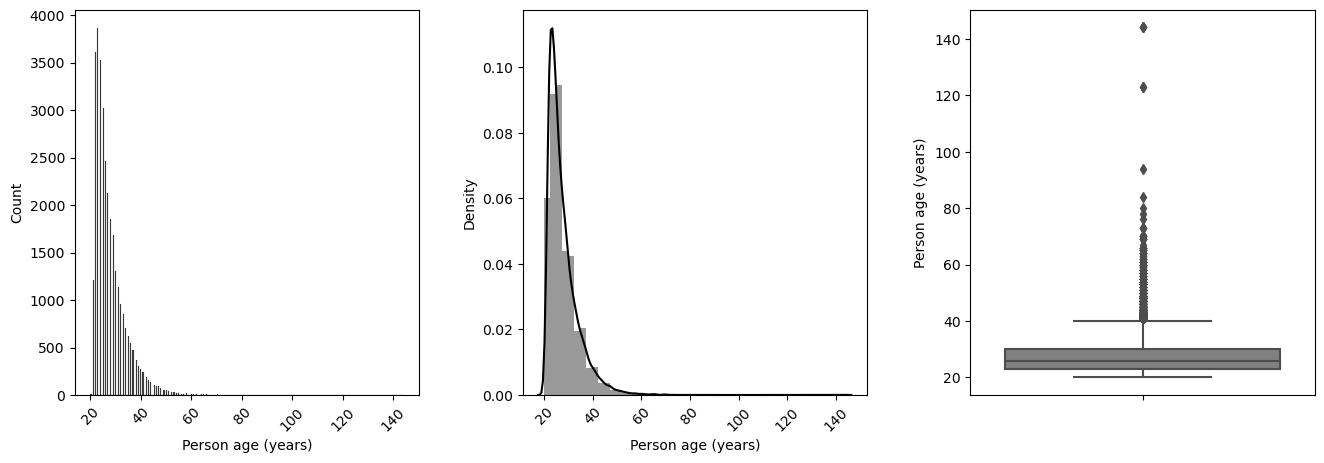

In [25]:
aux = num_attributes.copy()

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["person_age"], color="black")
plt.xlabel("Person age (years)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["person_age"], color="black")
plt.xlabel("Person age (years)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='person_age',data=aux, color="gray")
plt.ylabel("Person age (years)")

plt.subplots_adjust(wspace = 0.30);

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


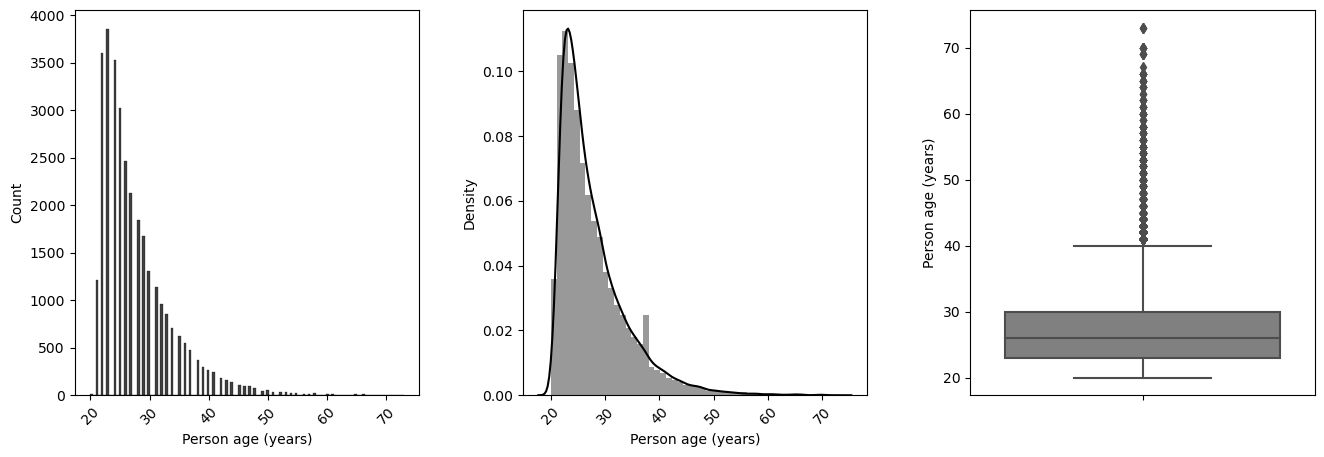

In [26]:
aux = num_attributes.copy()
aux = aux[aux["person_age"] <= 75]

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["person_age"], color="black")
plt.xlabel("Person age (years)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["person_age"], color="black")
plt.xlabel("Person age (years)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='person_age',data=aux, color="gray")
plt.ylabel("Person age (years)")

plt.subplots_adjust(wspace = 0.30);

In [27]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["person_age"]).describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32406.00,27.72,6.17,20.00,23.00,26.00,30.00,73.00


- Since we have a high value for kurtosis, we may assume there are outliers for person age.
- Therefore, median is more representative than mean.
- Median is around 26 years.
- A value lower than 75 should be used as upper limit to remove outliers.